In [1]:
# #@title Mount your Google Drive
# # If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# # you can delete this cell which is specific to Google Colab. You may also
# # change the paths for data/logs in Arguments below.
# %matplotlib inline
# %load_ext autoreload
# %autoreload 2

# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# #@title Link your assignment folder & install requirements
# #@markdown Enter the path to the assignment folder in your Google Drive
# # If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# # you can delete this cell which is specific to Google Colab. 
# import sys
# import os
# import shutil
# import warnings

# folder = "/content/gdrive/MyDrive/ift6759" #@param {type:"string"}
# !ln -Ts "$folder" /content/assignment 2> /dev/null

# # Add the assignment folder to Python path
# if '/content/assignment' not in sys.path:
#   sys.path.insert(0, '/content/assignment')

# # Check if CUDA is available
# import torch
# if not torch.cuda.is_available():
#   warnings.warn('CUDA is not available.')

## Imports

In [3]:
# !pip3 install torchxrayvision
# !pip3 install lightning

In [4]:
import torchxrayvision as xrv # for chest xray pretrained models
import skimage, torch, torchvision
import torchvision.models as models # for general pretrained models

C:\Users\STW\.conda\envs\ift6759\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


In [5]:
from skimage.io import imread
from torchvision import transforms
from torchvision.transforms import ToTensor
import torch.nn as nn
from torch import optim, nn, utils, Tensor
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import tqdm
import time
import copy
import os
import matplotlib.pyplot as plt
import pandas as pd
import tensorboard
import torchmetrics
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint

### Check that GPU is available

In [6]:
# Use GPU if it's available
import warnings
if not torch.cuda.is_available():
    warnings.warn('CUDA is not available')
    use_gpu = False
    device = torch.device('cpu')
else:
    use_gpu = True
    device = torch.device('cuda:0')

In [7]:
torch.cuda.is_available()

True

## Decide on hyperparameters and goals

In [8]:
# What is the task ('classification' or 'regression')
task = 'regression'

# If classification, how many classes?
if task == 'classification':
    final_out_features = 7
    
# If regression, final out features is 1
elif task == 'regression':
    final_out_features = 1
    
# What level of dropout do we want for the adaptor (classifier/regressor) head of the model?
head_dropout = 0.5

# How many epochs to train for?

num_epochs = 400

# What optimizer, learning rate and scheduler do we want for training?
learning_rate = 0.001
optimizer_type = 'AdamW' # Choose from 'SGD' or 'AdamW'

# Other train-val-test settings
split_lengths = [0.7, 0.299, 0.001] # Using the validation set as a test set
batch_size = 50

# Do we want to filter the dataset by chest xray views?
view = ['*'] # [other options are ['PA', 'AP']]

## Preliminaries: Helper classes and functions

### Lightning module for easy training

In [9]:
class LightningRegressor(pl.LightningModule):
    def __init__(self,model):
        super().__init__()
        self.model = model
        self.mse = torchmetrics.MeanSquaredError()
        self.mae = torchmetrics.MeanAbsoluteError()
        self.r2_score = torchmetrics.R2Score()
    
    def training_step(self, batch, batch_idx):
        x,y = batch
        # print(f'y: {y}')
        # Make prediction
        x = self.model(x)
        # print(f'x {x}')
        # Calculate and log loss
        loss = nn.functional.mse_loss(x,y)
        mean_squared_error = self.mse(x,y)
        mean_absolute_error = self.mae(x,y)
        r2_score = self.r2_score(x,y)
        to_log = {"train_loss": loss, 
                  "train_mse": mean_squared_error, 
                  "train_mae": mean_absolute_error,
                  'train_r2_score': r2_score}  # add more items if needed
        self.log_dict(to_log, on_step=False, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x,y = batch
        # Make prediction
        x = self.model(x)
        # Calculate and log loss
        loss = nn.functional.mse_loss(x,y)
        mean_squared_error = self.mse(x,y)
        mean_absolute_error = self.mae(x,y)        
        r2_score = self.r2_score(x,y)
        to_log = {"val_loss": loss, 
                  "val_mse": mean_squared_error,
                  "val_mae": mean_absolute_error,
                  'val_r2_score': r2_score}  # add more items if needed
        self.log_dict(to_log, on_step=False, on_epoch=True)
        return loss
        
    def test_step(self, batch, batch_idx):
        x,y = batch
        # Make prediction
        x = self.model(x)
        # Calculate and log loss
        loss = nn.functional.mse_loss(x,y)
        mean_squared_error = self.mse(x,y)
        mean_absolute_error = self.mae(x,y)        
        r2_score = self.r2_score(x,y)
        to_log = {"test_loss": loss, 
                  "test_mse": mean_squared_error, 
                  "test_mae": mean_absolute_error,
                  'test_r2_score': r2_score}  # add more items if needed
        self.log_dict(to_log, on_step=False, on_epoch=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr = 1e-3)
        return optimizer
    
class LightningClassifier(pl.LightningModule):
    def __init__(self,model, num_classes):
        super().__init__()
        self.model = model
        self.loss = nn.CrossEntropyLoss()
        self.acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.auroc = torchmetrics.AUROC(task = 'multiclass', num_classes=num_classes)
        self.confusion_matrix = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=num_classes)
        self.f1_score = torchmetrics.F1Score(task="multiclass", num_classes=num_classes)
        self.precision = torchmetrics.Precision(task="multiclass", num_classes=num_classes)
        self.recall = torchmetrics.Recall(task="multiclass", num_classes=num_classes)
        self.specificity = torchmetrics.Specificity(task="multiclass", num_classes=num_classes)
    
    def training_step(self, batch, batch_idx):
        x,y = batch
        # Make predictions
        x = self.model(x)
        # Calculate and log loss
        loss = self.loss(x,y)
        acc = self.acc(x,y)
        auroc = self.auroc(x,y)
#         confusion_matrix = self.confusion_matrix(x,y)
        f1_score = self.f1_score(x,y)
        precision = self.precision(x,y)
        recall = self.recall(x,y)
        specificity = self.specificity(x,y)
        to_log = {'train_loss': loss,
                  'train_acc': acc,
                  'train_auroc': auroc,
#                   'train_confusion_matrix': confusion_matrix,
                  'train_f1_score': f1_score ,
                  'train_precision': precision,
                  'train_recall': recall,
                  'train_specificity': specificity,
                  }  # add more items if needed
        self.log_dict(to_log, on_step=False, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x,y = batch
        # Make predictions
        x = self.model(x)
        # Calculate and log loss
        loss = self.loss(x,y)
        acc = self.acc(x,y)
        auroc = self.auroc(x,y)
#         confusion_matrix = self.confusion_matrix(x,y)
        f1_score = self.f1_score(x,y)
        precision = self.precision(x,y)
        recall = self.recall(x,y)
        specificity = self.specificity(x,y)
        to_log = {'val_loss': loss,
                  'val_acc': acc,
                  'val_auroc': auroc,
#                   'val_confusion_matrix': confusion_matrix,
                  'val_f1_score': f1_score ,
                  'val_precision': precision,
                  'val_recall': recall,
                  'val_specificity': specificity,
                  }  # add more items if needed
        self.log_dict(to_log, on_step=False, on_epoch=True)
        return loss
        
    def test_step(self, batch, batch_idx):
        x,y = batch
        # Make predictions
        x = self.model(x)
        # Calculate and log loss
        loss = self.loss(x,y)
        acc = self.acc(x,y)
        auroc = self.auroc(x,y)
#         confusion_matrix = self.confusion_matrix(x,y)
        f1_score = self.f1_score(x,y)
        precision = self.precision(x,y)
        recall = self.recall(x,y)
        specificity = self.specificity(x,y)
        to_log = {'test_loss': loss,
                  'test_acc': acc,
                  'test_auroc': auroc,
#                   'test_confusion_matrix': confusion_matrix,
                  'test_f1_score': f1_score ,
                  'test_precision': precision,
                  'test_recall': recall,
                  'test_specificity': specificity,
                  }  # add more items if needed
        self.log_dict(to_log, on_step=False, on_epoch=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr = 1e-3)
        return optimizer

### Custom Dataset class to get and transform data

In [10]:
class CovidSeverity_Dataset(Dataset):
    def __init__(self, img_dir, annotations_file, from_xrv = False, transform = None, views = ['*'], data_aug = False, task = 'regression'):
        self.image_dir = img_dir
        self.transform = transform
        self.from_xrv = from_xrv
        self.views = views
        self.data_aug = data_aug
        self.task = task

        # Load data labels
        self.csv = pd.read_csv(annotations_file, index_col=0).reset_index()
        
        # Set the labels based on the task
        if self.task == 'regression':
            self.image_labels = self.csv['OpacityScoreGlobal']
        elif self.task == 'classification':
            self.image_labels = self.csv['OpacityScoreGlobal'].round()

        # Keep only the selected views.
        self.limit_to_selected_views(views)
        
    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):
        # Read in the image
        image_filename = self.csv['filename'].iloc[idx]
        image_path = os.path.join(self.image_dir, image_filename)

        # If the associated model will be from torchxrayvision, convert to grayscale then normalize
        if self.from_xrv:
            image = torchvision.io.read_image(image_path, mode = torchvision.io.ImageReadMode.GRAY)
        else:
            image = torchvision.io.read_image(image_path, mode = torchvision.io.ImageReadMode.RGB)
        
        # Convert label to tensor
        label = self.image_labels[idx]
        if self.task == 'regression':
            label = torch.tensor(label, dtype = torch.float).unsqueeze(0)
        elif self.task == 'classification':
            label = torch.tensor(label).type(torch.LongTensor)   
        
        # Transform image
        if self.transform:
            image = self.transform(image.type(torch.uint8))
        # Apply data augmentation if specified
        if self.data_aug:
            image = self.data_aug(image)
        
        if self.from_xrv:
            image = (image - 127.5) / 127.5 * 1024 # Scales the image to between approx -1024 and 1024, from 0-255
        
        return image.type(torch.float32), label
    
    def limit_to_selected_views(self, views):
        """Filters the images by view based on the values in .csv['view']
        """
        if type(views) is not list:
            views = [views]
        if '*' in views:
            # if you have the wildcard, the rest are irrelevant
            views = ["*"]
        self.views = views

        # missing data is unknown
        self.csv.view.fillna("UNKNOWN", inplace=True)

        if "*" not in views:
            self.csv = self.csv[self.csv["view"].isin(self.views)]  # Select the view

### Transforms to apply to the data

In [11]:
# Define transforms
transform = transforms.Compose([
    transforms.RandomRotation(30),      # rotate +/- 30 degrees
    transforms.RandomHorizontalFlip(),  # rHorizontally flip the given image randomly with a given probability (default p=0.5)
    transforms.RandomAutocontrast(p=0.5),
    transforms.RandomEqualize(p=0.5),
    transforms.CenterCrop(224),
    ])

data_aug = False

### Function to get pretrained model and freeze weights

In [12]:
def load_model(model_name):
    """
    Loads a model from torchxrayvision or torchvision
    """
    # Set the chosen model as "model"
    # From torchxrayvision
    ## 224x224 models
    if model_name == 'densenet_all':
        model = xrv.models.DenseNet(weights="densenet121-res224-all")
    elif model_name == 'densenet_rsna':
        model = xrv.models.DenseNet(weights="densenet121-res224-rsna") # RSNA Pneumonia Challenge
    elif model_name == 'densenet_nih':
        model = xrv.models.DenseNet(weights="densenet121-res224-nih") # NIH chest X-ray8
    elif model_name == 'densenet_pc':
        model = xrv.models.DenseNet(weights="densenet121-res224-pc") # PadChest (University of Alicante)
    elif model_name == 'densenet_chex':
        model = xrv.models.DenseNet(weights="densenet121-res224-chex") # CheXpert (Stanford)
    elif model_name == 'densenet_mimic_nb':
        model = xrv.models.DenseNet(weights="densenet121-res224-mimic_nb") # MIMIC-CXR (MIT)
    elif model_name == 'densenet_mimic_ch':
        model = xrv.models.DenseNet(weights="densenet121-res224-mimic_ch") # MIMIC-CXR (MIT)

    # from torchvision
    elif model_name == 'densenet':
        model = models.densenet161(pretrained=True) # torchvision densenet pretrained on imagenet
    elif model_name == 'alexnet':
        model = models.alexnet(pretrained=True) 
    elif model_name == 'squeezenet':
        model = models.squeezenet1_0(pretrained=True)
    elif model_name == 'mobilenet':
        model = models.mobilenet_v2(pretrained=True)
    elif model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
    return model

### Function to change the classifier of the model

In [13]:
def adapt_model(model, model_name = 'densenet_all', task = 'regression', final_out_features = 1):
    """
    Adapt a model by changing the classification head
    """
    # If the model name is one of the following, it is from torchxrayvision
    if model_name in ['densenet_all', 'densenet_rsna', 'densenet_nih', 'densenet_pc', 
                      'densenet_chex', 'densenet_mimic_nb', 'densenet_mimic_ch']:
        from_xrv = True
    
    # Make a deep copy of the model
    model = copy.deepcopy(model)
    
    # Freeze weights in model
    for param in model.features.parameters():
        param.requires_grad = False
    
    # Get number of features flowing into the classifier layer we want to change
    # If the model is a densenet-161-based model (all of xrv, or densenet from torchvision)
    if model_name in ['densenet_all', 'densenet_rsna', 'densenet_nih', 'densenet_pc', 
                      'densenet_chex', 'densenet_mimic_nb', 'densenet_mimic_ch']:
        # The classifier is named 'classifier'
        in_features = model.classifier.in_features
        hidden_features = int(in_features/2) # note: this constriction was largely arbitrarily-decided
        
        # Kludge on an extra part after self.classifier. xrv gets snippy if you just try to change the classifier itself.
        extra = nn.Sequential(
            nn.Linear(18,hidden_features), # an xrv model outputs 18 features
            nn.ReLU(),
            nn.Linear(hidden_features,final_out_features)
        )
        model = nn.Sequential(model,extra)

    # If the model is one of the following, it can be accessed by .classifier[-1]
    elif model_name in ['alexnet', 'mobilenet', 'vgg16'] :
        in_features = model.classifier[-1].in_features
        # Change the last (linear) layer to have the desired number of output features
        model.classifier[-1] = nn.Linear(in_features, final_out_features)
        
    elif model_name in ['squeezenet'] :
        # Kludge on an extra part after self.classifier.
        extra = nn.Sequential(
            nn.Linear(1000,500),
            nn.ReLU(),
            nn.Linear(500,final_out_features)
        )
        model = nn.Sequential(model,extra)

    elif model_name == 'densenet':
        in_features = model.classifier.in_features
        hidden_features = int(in_features/2) # note: this constriction was largely arbitrarily-decided
        # Kludge on an extra part after self.classifier, to be comparable with xrv models
        extra = nn.Sequential(
            nn.Linear(1000,hidden_features), # an xrv model outputs 18 features
            nn.ReLU(),
            nn.Linear(hidden_features,final_out_features)
        )
        model = nn.Sequential(model,extra)
    
    return model

## Putting it all together: running training/validation

In [21]:
# Pretrained models from torchxrayvision:
# ['densenet_all', 'densenet_rsna', 'densenet_nih', 'densenet_pc', 'densenet_chex', 'densenet_mimic_nb', 'densenet_mimic_ch']
# Pretrained models from torchvision:
# ['alexnet','densenet', 'squeezenet', 'mobilenet', 'vgg16']

models_to_run= ['densenet_all', 'densenet_rsna', 'densenet_nih', 'densenet_pc', 
                    'densenet_chex', 'densenet_mimic_nb', 'densenet_mimic_ch', 'alexnet', 
                    'squeezenet', 'mobilenet', 'densenet', 'vgg16']

for model_name in models_to_run:
    print(model_name)
    if model_name in ['densenet', 'alexnet', 'squeezenet', 'mobilenet', 'vgg16']:
        from_xrv = False # Ensures the dataset is processed in a way the model expects
        # resulting images are (3,224,224)
    else: 
        from_xrv = True # Ensures the dataset is processed in a way the model expects
        # resulting images are (1,224,224)

    # Set up dataset
    combined_labels = "./data_processing/combined_cxr_metadata.csv"
    processed_images = "./processed_images"

    dataset = CovidSeverity_Dataset(processed_images, 
                                    combined_labels, 
                                    from_xrv = from_xrv, # defined above, cell 10
                                    transform = transform,
                                    views = view, # defined above, cell 10
                                    data_aug = data_aug, 
                                    task = task # defined above, cell 10
                                    )
    print(dataset[0][0].shape)
    # Split dataset into train, val, test
    # Split lengths and batch size are defined above

    train_split, val_split, test_split = random_split(dataset= dataset, 
                                                     lengths = split_lengths, # defined above, cell 10
                                                     generator = torch.Generator().manual_seed(42))

    train_loader = DataLoader(train_split, batch_size = batch_size, shuffle = True)
    val_loader = DataLoader(val_split, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(test_split, batch_size = batch_size, shuffle = True)

    # Get the model and adapt it for the task
    model = load_model(model_name)
    model = adapt_model(model, model_name = model_name, 
                        task = task, final_out_features = final_out_features)

    # Initialize the model with pytorch lightning module
    if task == 'classification':
        lightning_model = LightningClassifier(model, final_out_features)
    elif task == 'regression':
        lightning_model = LightningRegressor(model)

    # Set up custom loggers

    # logger = TensorBoardLogger(save_dir='/content/gdrive/MyDrive/ift6759/lightning_logs/', name='densenet_chex')
    #if local:
    csv_logger = CSVLogger(save_dir='lightning_logs/', 
                          name=f'{model_name}_{task}_{num_epochs}_epochs')
    tb_logger = TensorBoardLogger(save_dir='lightning_logs/', 
                                 name=f'{model_name}_{task}_{num_epochs}_epochs')
    # Set up checkpointing 
    checkpoint_callback = ModelCheckpoint(save_top_k = 2, 
                                          monitor='val_loss') 

    # Train model
    trainer = pl.Trainer(limit_train_batches = 100, max_epochs = num_epochs,
                        accelerator = 'auto',
                        enable_checkpointing = True,
                        logger = [csv_logger, tb_logger],
                        callbacks = [checkpoint_callback],
    #                     fast_dev_run = True # runs only one train/val to check code executes ok
                        )
    trainer.fit(model = lightning_model, 
                train_dataloaders = train_loader,
               val_dataloaders = val_loader
               )

    # Save entire model
    save_path = 'saved_models/'
    save_name = f'{model_name}_{task}_{num_epochs}_epochs.pt'

    torch.save(model, os.path.join(save_path, save_name))

vgg16
torch.Size([3, 224, 224])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | model    | VGG               | 134 M 
1 | mse      | MeanSquaredError  | 0     
2 | mae      | MeanAbsoluteError | 0     
3 | r2_score | R2Score           | 0     
-----------------------------------------------
119 M     Trainable params
14.7 M    Non-trainable params
134 M     Total params
537.059   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Visualize model decisions

In [14]:
def visualize_decision(image_path, csv_path, model_path, from_xrv):
    """
    Takes:
    image_path (str): An image path.
    model: A pytorch model (should be loaded separately before passing to this function).
    from_xrv (bool): Whether the model is from torchxrayvision.
    use_gpu (bool): Whether to use the gpu for prediction.

    Does a forward prediction pass on the image and 
    visualizes the gradient at the last layer that contributed 
    to the prediction.

    Returns the actual score, and the predicted score.
    """
    # Load model from save
    model = torch.load(model_path)

    # Load image

    # If it's from torchxrayvision, the model expects a grayscaled image
    if from_xrv:
        image = torchvision.io.read_image(image_path, mode = torchvision.io.ImageReadMode.GRAY)
        # Normalize image to what torchxrayvision expects
        image = (image - 127.5) / 127.5 * 1024 # Scales the image to between approx -1024 and 1024, from 0-255
    else:
        image = torchvision.io.read_image(image_path, mode = torchvision.io.ImageReadMode.RGB)

    # Load the ground truth label
    metadata = pd.read_csv(csv_path, index_col=0).reset_index() # Loads the csv
    image_name = os.path.basename(os.path.normpath(image_path)) # Gets the image name
    label = metadata['OpacityScoreGlobal'].loc[metadata['filename'] == image_name].values[0] # Gets the label with the correct filename

    # Process the image

    # transform image by doing a center crop to 224 pixels
    transform = transforms.Compose([
      transforms.CenterCrop(224),
      ])
    image = transform(image)

    # Set image to require grad so we can get the autograd
    image = image.requires_grad_()

    # If we have access to GPU, move image and model to GPU
    if torch.cuda.is_available():
        image = image.cuda()
        model = model.cuda()

    # Set to eval mode for reproducibility
    model.eval()

    # Make prediction on image using model
    prediction = model(image.unsqueeze(0)) # add a batch size of 1 in front so model accepts it

    # Get gradients
    gradients = torch.autograd.grad(prediction, image)[0][0]

    # Blur image of the gradients
    blurred = skimage.filters.gaussian(gradients.detach().cpu().numpy()**2, 
                                    sigma = (5,5),
                                    truncate = 3.5)

    fig, ax = plt.subplot_mosaic([['xray','preds']], figsize = (7,3.5))
    # Plot the original image on the left
    ax['xray'].imshow(image.squeeze().detach().cpu().numpy(), cmap='gray', aspect = 'auto')
    ax['xray'].set_title('Original')
    ax['xray'].axis('off')
    # Plot the original image, and the gradient overlay, on the right
    ax['preds'].imshow(image.squeeze().detach().cpu().numpy(), cmap='gray', aspect = 'auto')
    ax['preds'].imshow(blurred, alpha = 0.5)
    ax['preds'].set_title('Model focus')
    ax['preds'].axis('off')
    plt.tight_layout() # ensures that both images are the same size

    # Descriptive over-all title
    plt.suptitle(f'Actual: {label}, Prediction: {round(prediction.item(),3)}', y = 1.05);
    plt.savefig(f'{image_name}_{model_name}_pred.png')

    return label, round(prediction.item(),3)
    

In [21]:
# Paths to the csv and model that the visualize_decision function will use
csv_path = "./data_processing/combined_cxr_metadata.csv"
image_path_1 = './processed_images/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-000-fig1b.png'
save_path = './saved_models'
model_name = 'densenet_all'
if model_name in ['densenet', 'alexnet', 'squeezenet', 'mobilenet', 'vgg16']:
        from_xrv = False # Ensures the dataset is processed in a way the model expects
        # resulting images are (3,224,224)
else: 
    from_xrv = True # Ensures the dataset is processed in a way the model expects
    # resulting images are (1,224,224)
save_name = f'{model_name}_{task}_{num_epochs}_epochs.pt'
model_path = os.path.join(save_path, save_name)

(1.0, 1.223)

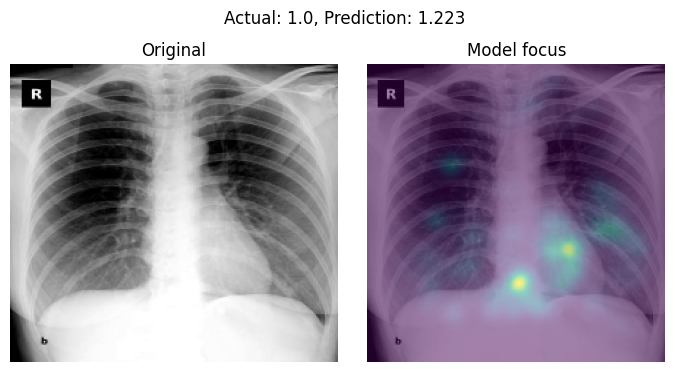

In [22]:
visualize_decision(image_path_1, csv_path, model_path, from_xrv)